# Introduction

`Can we approximately sample from a Bayesian posterior distribution if we are only allowed to touch a small mini-batch of data-items for every sample we generate ?`

For large high dimensional datasets, nature of relationships between model parameters and the variability of uncertainty reduction in the parameters can be measured with bayesian models and sampling algorithms.

The capacity of sampling algorithms to sample from exact or approximate bayesian posterior of the parameters in reasonable time is therefore very useful.

Based on results from a recent paper, a simple implementation of constant stochastic gradient is shown to have approximately sampling from the posterior. The goal of this notebook is the replicate the results and test the algorithm on a very large dataset.

Ref: https://arxiv.org/abs/1704.04289

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
from collections import OrderedDict
import warnings
import theano
import numpy as np
rng = np.random.RandomState(0)

In [3]:
import pandas as pd
import theano.tensor as tt
import seaborn as sns

# Sampling: Constant Stochastic Gradient

# Problem: A multivariate regression problem on the Protein Structure Properties dataset available at the [uci repo](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure).

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv --directory-prefix=/tmp/

--2017-11-13 20:24:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3528710 (3.4M) [text/csv]
Saving to: ‘/tmp/CASP.csv.7’

CASP.csv.7          100%[===================>]   3.37M  3.55MB/s    in 0.9s    

2017-11-13 20:24:26 (3.55 MB/s) - ‘/tmp/CASP.csv.7’ saved [3528710/3528710]



### Load dataset

In [5]:
raw_data = pd.read_csv('/tmp/CASP.csv', delimiter=',')
data = (raw_data - raw_data.mean())/raw_data.std()
q_size = data.shape[1]-1
q_name = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']

In [6]:
data_N = data.size/len(data.columns)
train_test_split = 0.95
ixs = rng.randint(data_N, size=int(data_N*train_test_split))
neg_ixs = list(set(range(data_N)) - set(ixs))
train_df = data.iloc[ixs]
test_df = data.iloc[neg_ixs]

N = train_df.size / len(train_df.columns)
n_test = test_df.size / len(test_df.columns)

In [7]:
train_X = train_df[q_name].as_matrix()
train_Y = train_df['RMSD'].as_matrix()

test_X = test_df[q_name].as_matrix()
test_Y = test_df['RMSD'].as_matrix()

Let's try regression models from sklearn to construct the best pymc3 model

In [8]:
from sklearn import linear_model
sklearn_regression_model = {
    'Ridge': linear_model.Ridge (alpha = .5),
    'Lasso': linear_model.Lasso(alpha = 0.1),
    'BayesianRidge': linear_model.BayesianRidge(),
    'OLS': linear_model.LinearRegression(),
}
for name, reg in sklearn_regression_model.items():
    reg.fit(train_X, train_Y) 
    pred = reg.predict(test_X)
    diff = pred-test_Y
    print('The {} Mean Absolute Error is {}'.format(name, np.sum(np.abs(diff))/test_Y.size))

The BayesianRidge Mean Absolute Error is 0.705775225403
The OLS Mean Absolute Error is 0.705739946132
The Ridge Mean Absolute Error is 0.705748180444
The Lasso Mean Absolute Error is 0.798798476908


/Users/shashank/.virtualenvs/pym3/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Lasso penalty has the minimum mean absolute error so we will select priors such that the object function for the sampler has a lasso penalty 

In [9]:
model_input = theano.shared(train_X, name='X')
model_output = theano.shared(train_Y, name='Y')

with pm.Model() as model:
    b0 = pm.Normal("Intercept", mu=0.0, sd=1.0)
    # s (lasso feature selection parameter) ~ 1/b
    b1 = pm.Laplace("Slope", mu=0.0, shape=(q_size,), b=10)
    std = pm.HalfNormal("std", sd=1.0)

    mu = b0 + theano.dot(model_input, b1)      
    y_obs = pm.Normal("y_obs", mu=mu, sd=std, observed=model_output) 

In [10]:
with model:
    start = pm.find_MAP()
    
map_pred = np.matmul(test_X, start['Slope'] ) + start['Intercept']
map_diff = map_pred-test_Y
print('The {} Mean Absolute Error is {}'.format("BayesianLasso", np.sum(np.abs(map_diff))/test_Y.size))

         Current function value: 54433.024816
         Iterations: 22
         Function evaluations: 94
         Gradient evaluations: 84
The BayesianLasso Mean Absolute Error is 0.70574090958


A mean absolute error of ~0.706 is the expected error from the mean of the posterior if its unimodal

Make model and minibatches input for the stochastic sampler

In [11]:
draws = 20000
with model:
    nuts_trace = pm.sample(draws=draws)     

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 20500/20500 [29:00<00:00, 11.78it/s]


In [13]:
model_input = theano.shared(train_X, name='X')
model_output = theano.shared(train_Y, name='Y')

with pm.Model() as model:
    
    c = pm.Normal("Intercept", mu=0.0, sd=1.0)
    # s (lasso feature selection parameter) ~ 1/b
    mu = pm.Laplace("Slope", mu=0.0, shape=(q_size,), b=1./10)

    std = pm.HalfNormal("std", sd=1.0)

    y_est = c + theano.dot(model_input, mu)      
    y_obs = pm.Normal("y_obs", mu=y_est, sd=std, observed=model_output) 
    
# Generator that returns mini-batches in each iteration
def create_minibatches(batch_size):
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(N, size=batch_size)
        yield (train_X[ixs], train_Y[ixs])

# Tensors and RV that wil l be using mini-batches
batch_size = 50
minibatches = create_minibatches(batch_size)
minibatch_tensors = [model_input, model_output]

In [14]:
with model:
    csg_step_method = pm.step_methods.ConstantStochasticGradient(vars=model.vars,
                                                                 model=model,
                                                                 total_size=N, 
                                                                 batch_size=batch_size,
                                                                 minibatches=minibatches, 
                                                                 minibatch_tensors=minibatch_tensors) 
    csg_trace = pm.sample(draws=draws, step=csg_step_method, init=None) 

/Users/shashank/.virtualenvs/pym3/lib/python2.7/site-packages/pymc3-3.1-py2.7.egg/pymc3/step_methods/sgmcmc.py:110: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
100%|██████████| 20500/20500 [00:40<00:00, 504.66it/s]


In [19]:
model_input = theano.shared(train_X, name='X')
model_output = theano.shared(train_Y, name='Y')

with pm.Model() as model:
    
    c = pm.Normal("Intercept", mu=0.0, sd=1.0)
    # s (lasso feature selection parameter) ~ 1/b
    mu = pm.Laplace("Slope", mu=0.0, shape=(q_size,), b=1./10)

    std = pm.HalfNormal("std", sd=1.0)

    y_est = c + theano.dot(model_input, mu)      
    y_obs = pm.Normal("y_obs", mu=y_est, sd=std, observed=model_output) 
    
# Generator that returns mini-batches in each iteration
def create_minibatches(batch_size):
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(N, size=batch_size)
        yield (train_X[ixs], train_Y[ixs])

# Tensors and RV that wil l be using mini-batches
minibatches = create_minibatches(batch_size)
minibatch_tensors = [model_input, model_output]

In [20]:
with model:
    sgfs_step_method = pm.step_methods.SGFS(vars=model.vars,
                                            step_size=0.1,
                                            step_size_decay=500,
                                            total_size=N,
                                            batch_size=batch_size,
                                            minibatches=minibatches, 
                                            minibatch_tensors=minibatch_tensors)  
    sgfs_trace = pm.sample(draws=draws, step=sgfs_step_method, init=None)    

100%|██████████| 20500/20500 [00:40<00:00, 502.10it/s]


## NUTS Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12087a690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122f2c390>]], dtype=object)

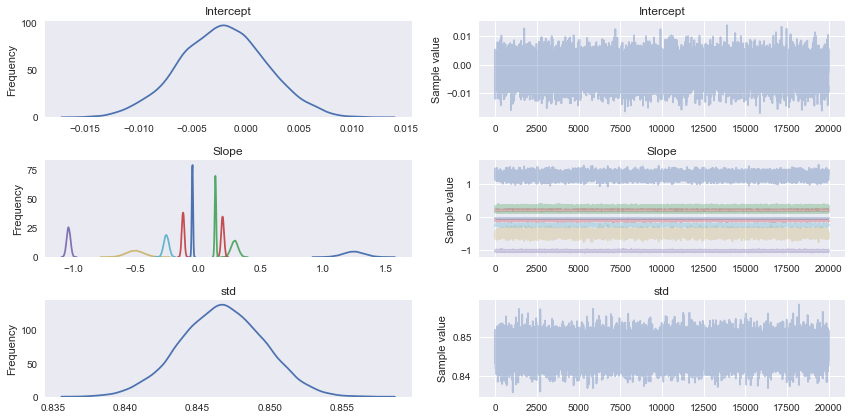

In [21]:
pm.traceplot(nuts_trace)

## Preconditioned CSG Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12342d7d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c38ba90>]], dtype=object)

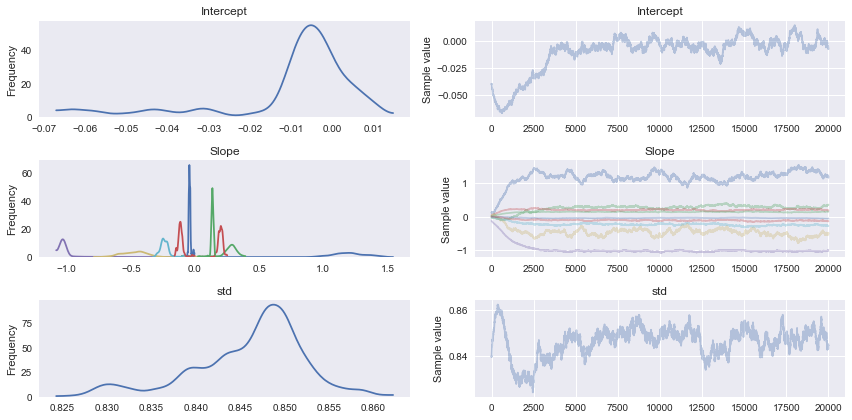

In [22]:
pm.traceplot(csg_trace)

## SGFS Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121589d10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1241bea50>]], dtype=object)

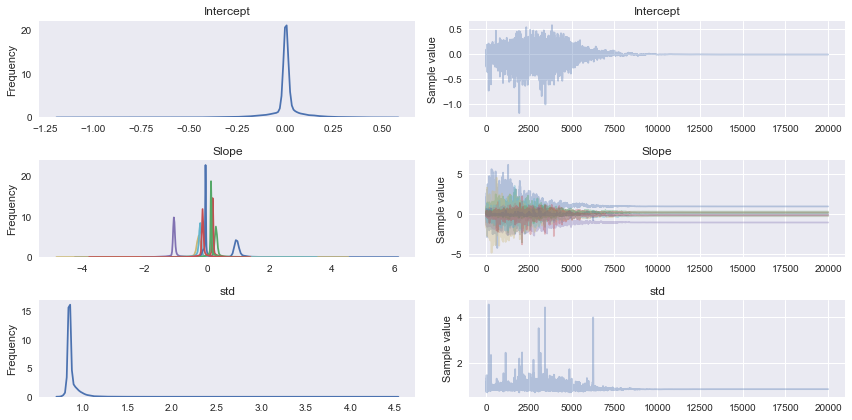

In [23]:
pm.traceplot(sgfs_trace)

## Mean Absolute Error on Test Dataset

In [24]:
# Replace shared variables with testing set
model_input.set_value(test_X)
model_output.set_value(test_Y)

samples = 1000

# Creater posterior predictive samples
sgfs_ppc = pm.sample_ppc(sgfs_trace, model=model, samples=samples, random_seed=0)
sgfs_pred = sgfs_ppc['y_obs'].mean(axis=0)

# Creater posterior predictive samples
csg_ppc = pm.sample_ppc(csg_trace, model=model, samples=samples, random_seed=0)
csg_pred = csg_ppc['y_obs'].mean(axis=0)

# Nuts predictive samples
nuts_ppc = pm.sample_ppc(nuts_trace, model=model, samples=samples, random_seed=0)
nuts_pred = nuts_ppc['y_obs'].mean(axis=0)

sgfs_diff = sgfs_pred-test_Y
csg_diff = csg_pred-test_Y
nuts_diff = nuts_pred-test_Y

100%|██████████| 1000/1000 [00:01<00:00, 683.17it/s]


In [25]:
print('The NUTS Mean Absolute Error is {}'.format(np.sum(np.abs(nuts_diff))/test_Y.size))
print('The CSG Mean Absolute Error is {}'.format(np.sum(np.abs(csg_diff))/test_Y.size))
print('The SGFS Mean Absolute Error is {}'.format(np.sum(np.abs(sgfs_diff))/test_Y.size))

The NUTS Mean Absolute Error is 0.705892661562
The CSG Mean Absolute Error is 0.708655587424
The SGFS Mean Absolute Error is 0.705152649591


The mean absolute error for all the sampling algorithms is less than 0.71. 
It is worse than the sklearn lasso regression implementation which has a mean absolute error of 0.79 due to approximations in the bayesian inference procedure
the results are not identical.

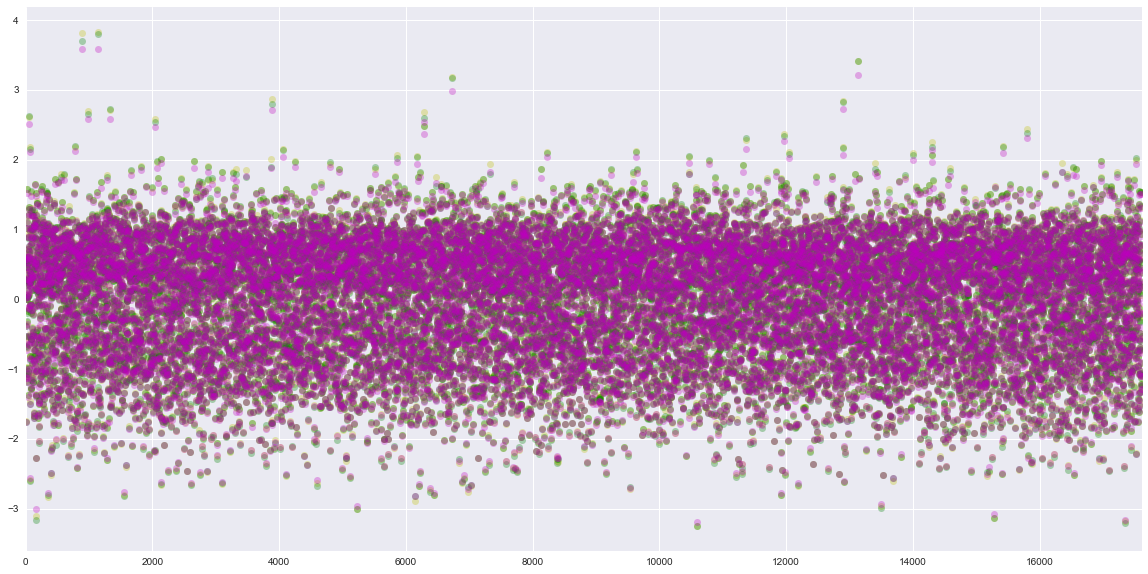

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.tsplot(data=nuts_diff, ax=ax, color="y", interpolate=False, alpha=0.3)
sns.tsplot(data=sgfs_diff, ax=ax, color="g", interpolate=False, alpha=0.3)
sns.tsplot(data=csg_diff, ax=ax, color="m", interpolate=False, alpha=0.3)

### Figure 1

Posterior distribution f(θ) ∝ exp{−N (θ)} (blue) and stationary sampling distributions q(θ) of the iterates of SGD (cyan) 

In [27]:
def posterior_covariance(step_method, trace):
    bij = pm.DictToArrayBijection(step_method.ordering, step_method.model.test_point)
    q_size = bij.map(step_method.model.model.test_point).size
    sample_size = len(trace)
    posterior = np.empty((q_size, sample_size))
    for index, point in enumerate(trace):
        posterior[:, index] = bij.map(point)
    posterior_minus_mean = posterior - np.asmatrix(posterior.mean(axis=1)).T
    cov = np.matmul(posterior_minus_mean, posterior_minus_mean.T)
    return posterior_minus_mean, cov

def projection(posterior, cov):
    U, S, V_h = np.linalg.svd(a=cov, compute_uv=True, full_matrices=True)
    first_projection = V_h[0, :]
    last_projection = V_h[-1, :]
    q_size, samples = posterior.shape
    projection_matrix = np.empty((samples, 2))
    for i in range(samples):
        projection_matrix[i, 0] = np.matmul(first_projection, posterior_minus_mean[:, i])
        projection_matrix[i, 1] = np.matmul(last_projection, posterior_minus_mean[:, i])
    return projection_matrix

burn_in = 500

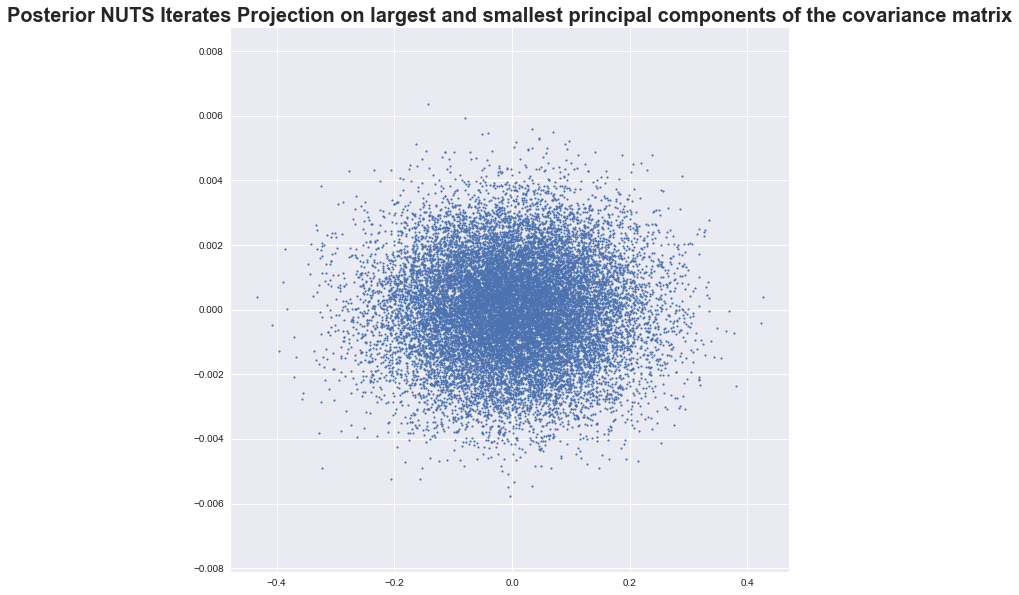

In [28]:
posterior_minus_mean, cov = posterior_covariance(csg_step_method, nuts_trace[burn_in:])
projection_matrix = projection(posterior_minus_mean, cov)
df = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Posterior NUTS Iterates Projection on largest and smallest principal components of the covariance matrix",
             fontsize=20, fontweight='bold')
plt.scatter(x=df['X'], y=df['Y'],s=3)

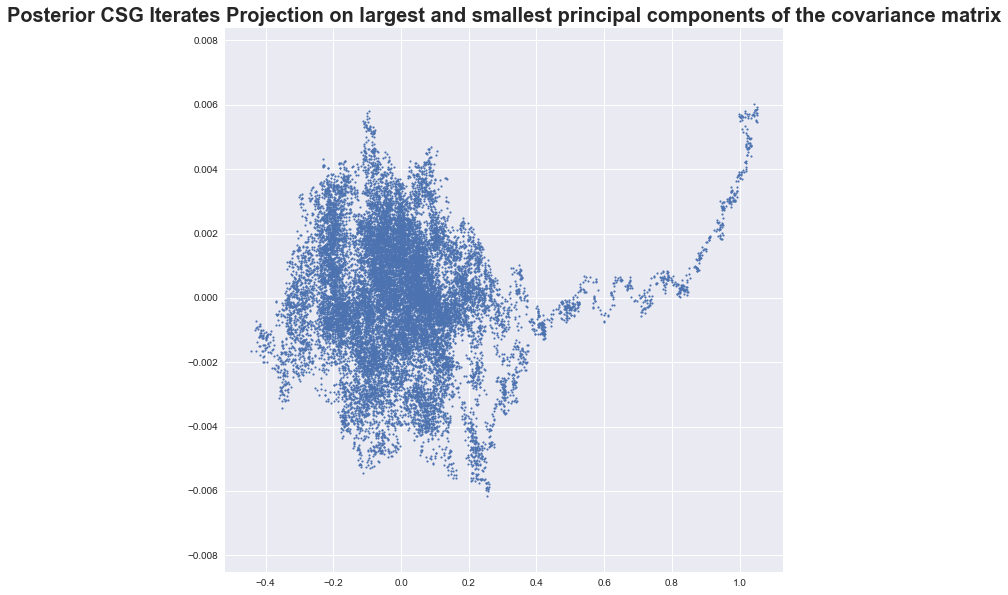

In [29]:
posterior_minus_mean, cov = posterior_covariance(csg_step_method, csg_trace[burn_in:])
projection_matrix = projection(posterior_minus_mean, cov)
df = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Posterior CSG Iterates Projection on largest and smallest principal components of the covariance matrix",
             fontsize=20, fontweight='bold')
plt.scatter(x=df['X'], y=df['Y'], s=3)

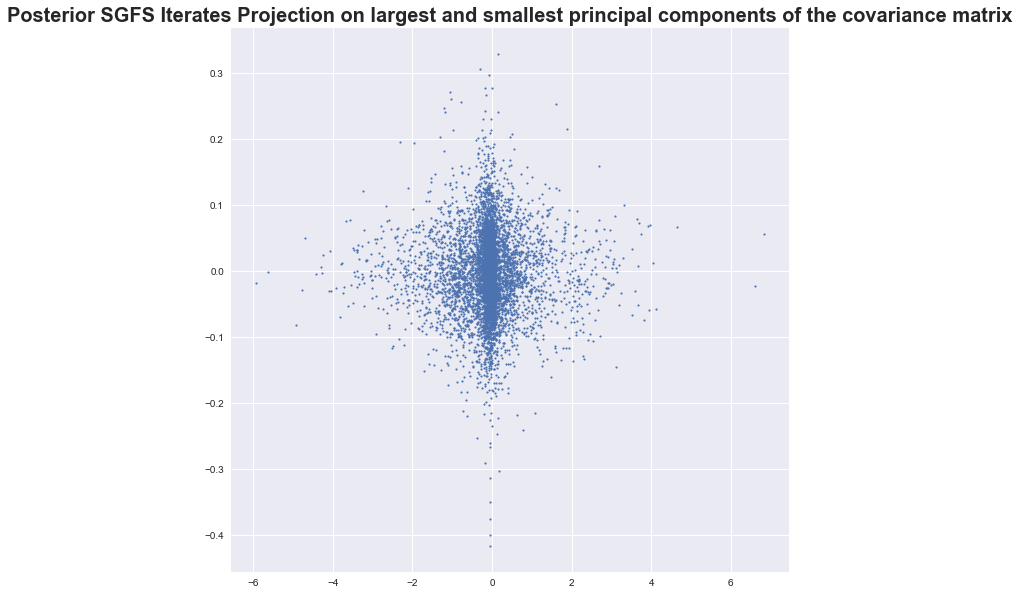

In [30]:
posterior_minus_mean, cov = posterior_covariance(sgfs_step_method, sgfs_trace[500:])
projection_matrix = projection(posterior_minus_mean, cov)
df = pd.DataFrame(projection_matrix, columns=['X', 'Y'])
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Posterior SGFS Iterates Projection on largest and smallest principal components of the covariance matrix",
             fontsize=20, fontweight='bold')
plt.scatter(x=df['X'], y=df['Y'], s=3)

# Conclusion

The Constant Stochastic Gradient is a good approximator of the posterior. It is expected that samples have independent projections on the largest and smallest 
components of the covariance matrix, and it is clearly observable that samples from CSG and NUTS are more spread out. 
The exponentially decreasing learning step size in SGFS forces convergence and reduces the exploration of the parameter
space by SGFS. CSG seems like a better approximator of the posterior distribution and it is equally efficient computationally.